# Twitter Gender Classification
### Final Project

#### University of California, Santa Barbara
#### PSTAT 135: Big Data Analytics

Source: https://www.kaggle.com/crowdflower/twitter-user-gender-classification

# Dataset Preprocessing

The dataset contains about 20,000 rows, each with a user name, a random tweet, profile image and statistics, location, and link and sidebar color. All tweets were posted in 2015.

In [1]:
from pyspark.sql import SparkSession
spark = SparkSession \
        .builder \
        .appName("comm") \
        .getOrCreate()

tweets = spark.read.csv('gender_data.csv', header = True)

In [2]:
type(tweets)

pyspark.sql.dataframe.DataFrame

In [3]:
tweets.count()

24230

In [4]:
tweets.columns

['_unit_id',
 '_golden',
 '_unit_state',
 '_trusted_judgments',
 '_last_judgment_at',
 'gender',
 'gender:confidence',
 'profile_yn',
 'profile_yn:confidence',
 'created',
 'description',
 'fav_number',
 'gender_gold',
 'link_color',
 'name',
 'profile_yn_gold',
 'profileimage',
 'retweet_count',
 'sidebar_color',
 'text',
 'tweet_coord',
 'tweet_count',
 'tweet_created',
 'tweet_id',
 'tweet_location',
 'user_timezone']

We remove columns `_unit_id`, `_golden`, `_unit_state`, `_last_judgment_at`,`_trusted_judgments`, `gender:confidence`, `profile_yn`, `profile_yn:confidence`, `description`, `gender_gold`, `link_color`,`name`, `profile_yn_gold`, `profileimage`, `sidebar_color`, `tweet_coord`, `tweet_id`, `tweet_location`, and `user_timezone` because they were not relevant in our model/purpose....

In [5]:
tweets = tweets.select(['gender','created','fav_number','retweet_count','text','tweet_count','tweet_created'])
tweets.show(5)

+------+--------------+----------+-------------+--------------------+-----------+--------------+
|gender|       created|fav_number|retweet_count|                text|tweet_count| tweet_created|
+------+--------------+----------+-------------+--------------------+-----------+--------------+
|  male|  12/5/13 1:48|         0|            0|Robbie E Responds...|     110964|10/26/15 12:40|
|  male| 10/1/12 13:51|        68|            0|���It felt like t...|       7471|10/26/15 12:40|
|  male|11/28/14 11:30|      7696|            1|i absolutely ador...|       5617|10/26/15 12:40|
|  male| 6/11/09 22:39|       202|            0|Hi @JordanSpieth ...|       1693|10/26/15 12:40|
|female| 4/16/14 13:23|     37318|            0|Watching Neighbou...|      31462|10/26/15 12:40|
+------+--------------+----------+-------------+--------------------+-----------+--------------+
only showing top 5 rows



In [6]:
tweets.groupBy('gender').count().sort('count', ascending = False).show()

+--------------------+-----+
|              gender|count|
+--------------------+-----+
|              female| 6700|
|                male| 6194|
|               brand| 5942|
|                null| 3188|
|             unknown| 1117|
|          6.5874E+17|   83|
|          6.5873E+17|   62|
|              Medina|   14|
|              London|   13|
|      10/26/15 12:40|   11|
|Porto, Portugal �...|   10|
|1/16 cute pickle ...|   10|
|              0084B4|    9|
|Republic of the P...|    8|
|                  UK|    7|
|                 USA|    7|
|         3/4 + band |    6|
|              FF005E|    6|
|PRE-ORDER MADE IN...|    5|
|           New York |    4|
+--------------------+-----+
only showing top 20 rows



As we can see above, the `gender` column contains many labels. We decide to keep only the tweets made by a `male`, `female`, or `brand` since they are the most common.

In [7]:
tweets = tweets.filter((tweets.gender == 'male') | (tweets.gender == 'female') | (tweets.gender == 'brand'))
tweets.count()

18836

### Checking for Null Values

We will remove any null values in `text` since we are only interested in predicting gender for users with tweets.

In [8]:
# Number of null values in "text"
tweets.filter(tweets.text.isNull()).count()

1088

In [9]:
tweets = tweets.filter(tweets.text.isNotNull())
tweets.count()

17748

For columns `fav_number`, `retweet_count`, and `tweet_count`:

- If more than 10% of the values are null, we will not include that column later on in our model. 

- If less than 10% of the values are null, we will replace null values with the median of that specific column. We chose median because there is a possibility the mean could be something like 77.5, and you cannot retweet something 77.5 times.

- If there are no null values, we will keep the column unchanged.

In [10]:
# Percentage of null values in "fav_number"
tweets.filter(tweets.fav_number.isNull()).count()/tweets.count()

0.0

In [11]:
# Percentage of null values in "retweet_count"
tweets.filter(tweets.retweet_count.isNull()).count()/tweets.count()

0.0

In [12]:
# Percentage of null values in "tweet_count"
tweets.filter(tweets.tweet_count.isNull()).count()/tweets.count()

0.07093757043047104

Since less than 10% of `tweet_count` values are null, we will replace them with the median value of `tweet_count` during pipeline building.

# Exploratory Data Analysis

In [13]:
tweets.groupBy('gender').count().orderBy('count',ascending=False).show()

+------+-----+
|gender|count|
+------+-----+
|female| 6354|
|  male| 5776|
| brand| 5618|
+------+-----+



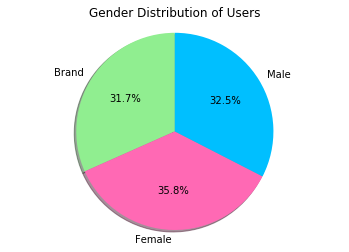

In [14]:
# Pie chart of genders
import matplotlib.pyplot as plt
labels = 'Brand', 'Female', 'Male'
sizes = [5618, 6354, 5776]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90, colors=['lightgreen', 'hotpink', 'deepskyblue'])
ax1.axis('equal')
plt.title('Gender Distribution of Users')
plt.show()

In [15]:
tweets.groupBy('gender') \
    .agg({'fav_number':'avg','retweet_count':'avg','tweet_count':'avg'}).show()

+------+-----------------+-----------------+-------------------+
|gender| avg(tweet_count)|  avg(fav_number)| avg(retweet_count)|
+------+-----------------+-----------------+-------------------+
|female|26868.96356206368|6039.206956248033|0.04737173434057287|
| brand| 63219.3443287037|2086.142043431826|0.11765752936988252|
|  male|30534.52625698324|4929.307825484764|0.09279778393351801|
+------+-----------------+-----------------+-------------------+



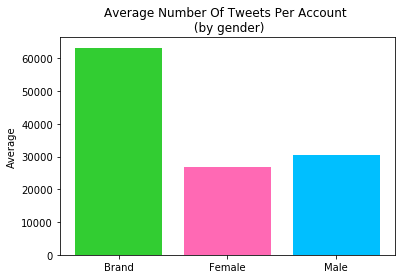

In [16]:
# Bar Plot of average number of tweets per account by gender
tweet_count_x = ['Brand', 'Female', 'Male']
tweet_count_avg = [63219.344329, 26868.963562, 30534.526257]
x_pos = [i for i, _ in enumerate(tweet_count_x)]
plt.bar(tweet_count_x, tweet_count_avg, color=['limegreen','hotpink','deepskyblue'])
plt.ylabel("Average")
plt.title("Average Number Of Tweets Per Account \n (by gender)")
plt.xticks(x_pos, tweet_count_x)
plt.show()

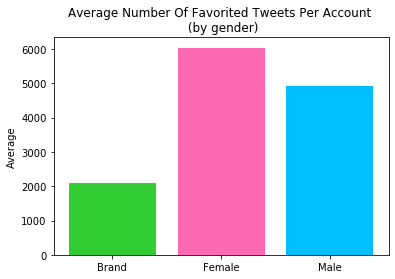

In [17]:
# Bar Plot of average number of favorites per account by gender
fav_number_x = ['Brand', 'Female', 'Male']
fav_number_avg = [2086.142043431826, 6039.206956248033, 4929.307825484764]
x_pos = [i for i, _ in enumerate(fav_number_x)]
plt.bar(fav_number_x, fav_number_avg, color=['limegreen','hotpink','deepskyblue'])
plt.ylabel("Average")
plt.title("Average Number Of Favorited Tweets Per Account \n (by gender)")
plt.xticks(x_pos, fav_number_x)
plt.show()

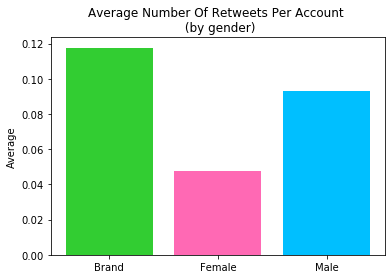

In [18]:
# Bar Plot of average number of retweets per account by gender
retweet_count_x = ['Brand', 'Female', 'Male']
retweet_count_avg = [0.11765752936988252, 0.04737173434057287, 0.09279778393351801]
x_pos = [i for i, _ in enumerate(retweet_count_x)]
plt.bar(retweet_count_x, retweet_count_avg, color=['limegreen','hotpink','deepskyblue'])
plt.ylabel("Average")
plt.title("Average Number Of Retweets Per Account \n (by gender)")
plt.xticks(x_pos, retweet_count_x)
plt.show()

### Converting Columns to Type Integer

In [19]:
tweets = tweets.withColumn("fav_number",tweets["fav_number"].cast('integer'))
tweets = tweets.withColumn("retweet_count",tweets["retweet_count"].cast('integer'))
tweets = tweets.withColumn("tweet_count",tweets["tweet_count"].cast('integer'))

### Creating New Columns for Punctuation Counts, Emoji Existence, and Account Years

Getting punctuation counts for each tweet.

In [20]:
from string import punctuation
from collections import Counter
def punc_func(tweet):
    sum = 0
    for key in tweet:
        if key in punctuation:
            sum += tweet[key]
    return sum

In [21]:
punc = tweets.select("text").rdd.map(lambda tweet: Counter(str(tweet))) \
            .map(lambda x: punc_func(x)).map(lambda x: (x, )).toDF(['punc'])
punc.show(5)

+----+
|punc|
+----+
|  11|
|  18|
|   5|
|  19|
|  15|
+----+
only showing top 5 rows



Getting boolean values if an emoji, represented by the character '�', is present in a tweet (True) or not present in a tweet (False).

In [22]:
emojis = tweets.select("text").rdd.map(lambda tweet: str(tweet)) \
            .map(lambda x: '�' in x).map(lambda x: (x, )).toDF(['emojis'])
emojis.show(5)

+------+
|emojis|
+------+
| false|
|  true|
| false|
| false|
|  true|
+------+
only showing top 5 rows



Getting the number of years each Twitter user has had their account.

In [23]:
# extracting only the "year" part of 'created' & subtracting it from 15 (representing 2015)
years = tweets.rdd.map(lambda row: row['created'].split(' ')) \
                .map(lambda x: x[0]) \
                .map(lambda x: x.split('/')) \
                .map(lambda x: x[2]) \
                .map(lambda x: (15-int(x))) \
                .map(lambda x: (x, )).toDF(['account_years'])
years.show(5)

+-------------+
|account_years|
+-------------+
|            2|
|            3|
|            1|
|            6|
|            1|
+-------------+
only showing top 5 rows



### Lowercasing Tweets

The last step before we configure our first pipeline is to lowercase the tweets in `text` column.

In [24]:
from pyspark.sql.functions import lower, col
tweets = tweets.withColumn("text",lower(col('text')))
tweets.select("text").show(1, truncate=False)

+-------------------------------------------------------------------------------------------------------------+
|text                                                                                                         |
+-------------------------------------------------------------------------------------------------------------+
|robbie e responds to critics after win against eddie edwards in the #worldtitleseries https://t.co/nsybbmvjkz|
+-------------------------------------------------------------------------------------------------------------+
only showing top 1 row



# Pipeline Building

In [25]:
from pyspark.ml import Pipeline  
from pyspark.ml.feature import * 

### Pipeline 1
For our first pipeline we:
- impute median values in `tweet_count`
- convert `gender` to numeric type
- tokenize and remove stop words in `text`

In [26]:
# impute median to null values in "tweet_count"
imputer = Imputer(inputCols=["tweet_count"], outputCols=["tweet_count_new"]).setStrategy("median")

# convert "gender" to numeric type (0 = female, 1 = male, 2 = brand)
indexer = StringIndexer(inputCol="gender", outputCol="gender_num")

# process "text"
tokenizer = Tokenizer(inputCol="text", outputCol="words") #tokenize
remover = StopWordsRemover(inputCol="words", outputCol="filtered") #remove stop words

# build pipeline
pipeline = Pipeline(stages=[imputer, indexer, tokenizer, remover])

# fit & tranform pipeline
tweets = pipeline.fit(tweets).transform(tweets)

Since ML Feature library does not support stemming, we decide to stem the `text` column using the `SnowballStemmer` package.

In [27]:
from pyspark.sql.functions import udf
from nltk.stem.snowball import SnowballStemmer
from pyspark.sql.types import ArrayType, StringType

stemmer = SnowballStemmer(language='english')
stemmer_udf = udf(lambda tokens: [stemmer.stem(token) for token in tokens], ArrayType(StringType()))
stemmed = tweets.withColumn("stemmed", stemmer_udf("filtered")).select("stemmed")
stemmed.show(1, truncate=False)

+----------------------------------------------------------------------------------------+
|stemmed                                                                                 |
+----------------------------------------------------------------------------------------+
|[robbi, e, respond, critic, win, eddi, edward, #worldtitleseri, https://t.co/nsybbmvjkz]|
+----------------------------------------------------------------------------------------+
only showing top 1 row



### Top 20 Words Used by Gender

### Adding Columns to `tweets`
We add `stemmed`,`punc`,`emojis`, and `account_years` to our updated dataset `tweets` from pipeline 1.

In [28]:
from pyspark.sql.functions import monotonically_increasing_id, row_number
from pyspark.sql.window import Window

In [29]:
tweets_new = tweets.withColumn('row_index', row_number().over(Window.orderBy(monotonically_increasing_id())))
punc_new = punc.withColumn('row_index', row_number().over(Window.orderBy(monotonically_increasing_id())))
emojis_new = emojis.withColumn('row_index', row_number().over(Window.orderBy(monotonically_increasing_id())))
years_new=years.withColumn('row_index', row_number().over(Window.orderBy(monotonically_increasing_id())))
stemmed_new = stemmed.withColumn('row_index', row_number().over(Window.orderBy(monotonically_increasing_id())))

In [30]:
tweets = tweets_new.join(punc_new, on=["row_index"]).join(emojis_new, on=["row_index"]) \
            .join(years_new, on=["row_index"]).join(stemmed_new, on=["row_index"])

In [31]:
tweets.columns

['row_index',
 'gender',
 'created',
 'fav_number',
 'retweet_count',
 'text',
 'tweet_count',
 'tweet_created',
 'tweet_count_new',
 'gender_num',
 'words',
 'filtered',
 'punc',
 'emojis',
 'account_years',
 'stemmed']

### Pipeline 2
For our second pipeline we:
- compute term frequency vector for `stemmed`
- create `bigrams` from `stemmed`
- compute term frequency vector for `bigrams`
- combine all relevant columns into `features` using VectorAssembler
- scale `features`

In [32]:
htf = HashingTF(inputCol="stemmed", outputCol="tf") #term frequencies for stemmed

bigrams = NGram(n=2, inputCol="stemmed", outputCol="bigrams") #create bigrams
bhtf = HashingTF(inputCol="bigrams", outputCol="btf") #term frequencies for bigrams

In [33]:
# build pipeline
pipeline = Pipeline(stages=[htf, bigrams, bhtf])

# fit & tranform pipeline
tweets = pipeline.fit(tweets).transform(tweets)

In [34]:
tweets.columns

['row_index',
 'gender',
 'created',
 'fav_number',
 'retweet_count',
 'text',
 'tweet_count',
 'tweet_created',
 'tweet_count_new',
 'gender_num',
 'words',
 'filtered',
 'punc',
 'emojis',
 'account_years',
 'stemmed',
 'tf',
 'bigrams',
 'btf']

In [42]:
from pyspark.ml.linalg import Vectors

tf = tweets.select('tf').rdd.map(lambda x: DenseVector(x.toArray())).map(lambda x: (x, )).toDF(['tf_dense'])

tf_df = tf.withColumn('row_index', row_number().over(Window.orderBy(monotonically_increasing_id())))
#tweets_2 = tweets.join(tf_df, on=["row_index"])

Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.runJob.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 91.0 failed 1 times, most recent failure: Lost task 0.0 in stage 91.0 (TID 668, jupyter-ishana-5fnarayanan, executor driver): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 605, in main
    process()
  File "/opt/conda/lib/python3.7/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 597, in process
    serializer.dump_stream(out_iter, outfile)
  File "/opt/conda/lib/python3.7/site-packages/pyspark/python/lib/pyspark.zip/pyspark/serializers.py", line 271, in dump_stream
    vs = list(itertools.islice(iterator, batch))
  File "/opt/conda/lib/python3.7/site-packages/pyspark/rdd.py", line 1440, in takeUpToNumLeft
    yield next(iterator)
  File "/opt/conda/lib/python3.7/site-packages/pyspark/python/lib/pyspark.zip/pyspark/util.py", line 107, in wrapper
    return f(*args, **kwargs)
  File "<ipython-input-42-6269eeb484ce>", line 3, in <lambda>
NameError: name 'DenseVector' is not defined

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:503)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:638)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:621)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:456)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator.foreach(Iterator.scala:941)
	at scala.collection.Iterator.foreach$(Iterator.scala:941)
	at org.apache.spark.InterruptibleIterator.foreach(InterruptibleIterator.scala:28)
	at scala.collection.generic.Growable.$plus$plus$eq(Growable.scala:62)
	at scala.collection.generic.Growable.$plus$plus$eq$(Growable.scala:53)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:105)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:49)
	at scala.collection.TraversableOnce.to(TraversableOnce.scala:315)
	at scala.collection.TraversableOnce.to$(TraversableOnce.scala:313)
	at org.apache.spark.InterruptibleIterator.to(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce.toBuffer(TraversableOnce.scala:307)
	at scala.collection.TraversableOnce.toBuffer$(TraversableOnce.scala:307)
	at org.apache.spark.InterruptibleIterator.toBuffer(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce.toArray(TraversableOnce.scala:294)
	at scala.collection.TraversableOnce.toArray$(TraversableOnce.scala:288)
	at org.apache.spark.InterruptibleIterator.toArray(InterruptibleIterator.scala:28)
	at org.apache.spark.api.python.PythonRDD$.$anonfun$runJob$1(PythonRDD.scala:154)
	at org.apache.spark.SparkContext.$anonfun$runJob$5(SparkContext.scala:2133)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:127)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:444)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1377)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:447)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2023)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:1972)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:1971)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1971)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:950)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:950)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:950)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2203)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2152)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2141)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:752)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2093)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2114)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2133)
	at org.apache.spark.api.python.PythonRDD$.runJob(PythonRDD.scala:154)
	at org.apache.spark.api.python.PythonRDD.runJob(PythonRDD.scala)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:748)
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 605, in main
    process()
  File "/opt/conda/lib/python3.7/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 597, in process
    serializer.dump_stream(out_iter, outfile)
  File "/opt/conda/lib/python3.7/site-packages/pyspark/python/lib/pyspark.zip/pyspark/serializers.py", line 271, in dump_stream
    vs = list(itertools.islice(iterator, batch))
  File "/opt/conda/lib/python3.7/site-packages/pyspark/rdd.py", line 1440, in takeUpToNumLeft
    yield next(iterator)
  File "/opt/conda/lib/python3.7/site-packages/pyspark/python/lib/pyspark.zip/pyspark/util.py", line 107, in wrapper
    return f(*args, **kwargs)
  File "<ipython-input-42-6269eeb484ce>", line 3, in <lambda>
NameError: name 'DenseVector' is not defined

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:503)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:638)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:621)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:456)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator.foreach(Iterator.scala:941)
	at scala.collection.Iterator.foreach$(Iterator.scala:941)
	at org.apache.spark.InterruptibleIterator.foreach(InterruptibleIterator.scala:28)
	at scala.collection.generic.Growable.$plus$plus$eq(Growable.scala:62)
	at scala.collection.generic.Growable.$plus$plus$eq$(Growable.scala:53)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:105)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:49)
	at scala.collection.TraversableOnce.to(TraversableOnce.scala:315)
	at scala.collection.TraversableOnce.to$(TraversableOnce.scala:313)
	at org.apache.spark.InterruptibleIterator.to(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce.toBuffer(TraversableOnce.scala:307)
	at scala.collection.TraversableOnce.toBuffer$(TraversableOnce.scala:307)
	at org.apache.spark.InterruptibleIterator.toBuffer(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce.toArray(TraversableOnce.scala:294)
	at scala.collection.TraversableOnce.toArray$(TraversableOnce.scala:288)
	at org.apache.spark.InterruptibleIterator.toArray(InterruptibleIterator.scala:28)
	at org.apache.spark.api.python.PythonRDD$.$anonfun$runJob$1(PythonRDD.scala:154)
	at org.apache.spark.SparkContext.$anonfun$runJob$5(SparkContext.scala:2133)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:127)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:444)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1377)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:447)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	... 1 more


In [40]:
tf_df.show(1)

Py4JJavaError: An error occurred while calling o495.showString.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 82.0 failed 1 times, most recent failure: Lost task 0.0 in stage 82.0 (TID 660, jupyter-ishana-5fnarayanan, executor driver): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 605, in main
    process()
  File "/opt/conda/lib/python3.7/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 597, in process
    serializer.dump_stream(out_iter, outfile)
  File "/opt/conda/lib/python3.7/site-packages/pyspark/python/lib/pyspark.zip/pyspark/serializers.py", line 271, in dump_stream
    vs = list(itertools.islice(iterator, batch))
  File "/opt/conda/lib/python3.7/site-packages/pyspark/python/lib/pyspark.zip/pyspark/util.py", line 107, in wrapper
    return f(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/pyspark/sql/types.py", line 606, in toInternal
    for f, v, c in zip(self.fields, obj, self._needConversion))
  File "/opt/conda/lib/python3.7/site-packages/pyspark/sql/types.py", line 606, in <genexpr>
    for f, v, c in zip(self.fields, obj, self._needConversion))
  File "/opt/conda/lib/python3.7/site-packages/pyspark/python/lib/pyspark.zip/pyspark/sql/types.py", line 444, in toInternal
    return self.dataType.toInternal(obj)
  File "/opt/conda/lib/python3.7/site-packages/pyspark/python/lib/pyspark.zip/pyspark/sql/types.py", line 687, in toInternal
    return self._cachedSqlType().toInternal(self.serialize(obj))
  File "/opt/conda/lib/python3.7/site-packages/pyspark/python/lib/pyspark.zip/pyspark/ml/linalg/__init__.py", line 164, in serialize
    values = [float(v) for v in obj]
  File "/opt/conda/lib/python3.7/site-packages/pyspark/python/lib/pyspark.zip/pyspark/ml/linalg/__init__.py", line 164, in <listcomp>
    values = [float(v) for v in obj]
TypeError: only size-1 arrays can be converted to Python scalars

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:503)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:638)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:621)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:456)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:489)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:458)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:458)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:729)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:458)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:132)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:52)
	at org.apache.spark.scheduler.Task.run(Task.scala:127)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:444)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1377)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:447)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2023)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:1972)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:1971)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1971)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:950)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:950)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:950)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2203)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2152)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2141)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:752)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2093)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2114)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2133)
	at org.apache.spark.sql.execution.SparkPlan.executeTake(SparkPlan.scala:467)
	at org.apache.spark.sql.execution.SparkPlan.executeTake(SparkPlan.scala:420)
	at org.apache.spark.sql.execution.CollectLimitExec.executeCollect(limit.scala:47)
	at org.apache.spark.sql.Dataset.collectFromPlan(Dataset.scala:3625)
	at org.apache.spark.sql.Dataset.$anonfun$head$1(Dataset.scala:2695)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$1(Dataset.scala:3616)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$5(SQLExecution.scala:100)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:160)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:87)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:763)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:64)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:3614)
	at org.apache.spark.sql.Dataset.head(Dataset.scala:2695)
	at org.apache.spark.sql.Dataset.take(Dataset.scala:2902)
	at org.apache.spark.sql.Dataset.getRows(Dataset.scala:300)
	at org.apache.spark.sql.Dataset.showString(Dataset.scala:337)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:748)
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 605, in main
    process()
  File "/opt/conda/lib/python3.7/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 597, in process
    serializer.dump_stream(out_iter, outfile)
  File "/opt/conda/lib/python3.7/site-packages/pyspark/python/lib/pyspark.zip/pyspark/serializers.py", line 271, in dump_stream
    vs = list(itertools.islice(iterator, batch))
  File "/opt/conda/lib/python3.7/site-packages/pyspark/python/lib/pyspark.zip/pyspark/util.py", line 107, in wrapper
    return f(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/pyspark/sql/types.py", line 606, in toInternal
    for f, v, c in zip(self.fields, obj, self._needConversion))
  File "/opt/conda/lib/python3.7/site-packages/pyspark/sql/types.py", line 606, in <genexpr>
    for f, v, c in zip(self.fields, obj, self._needConversion))
  File "/opt/conda/lib/python3.7/site-packages/pyspark/python/lib/pyspark.zip/pyspark/sql/types.py", line 444, in toInternal
    return self.dataType.toInternal(obj)
  File "/opt/conda/lib/python3.7/site-packages/pyspark/python/lib/pyspark.zip/pyspark/sql/types.py", line 687, in toInternal
    return self._cachedSqlType().toInternal(self.serialize(obj))
  File "/opt/conda/lib/python3.7/site-packages/pyspark/python/lib/pyspark.zip/pyspark/ml/linalg/__init__.py", line 164, in serialize
    values = [float(v) for v in obj]
  File "/opt/conda/lib/python3.7/site-packages/pyspark/python/lib/pyspark.zip/pyspark/ml/linalg/__init__.py", line 164, in <listcomp>
    values = [float(v) for v in obj]
TypeError: only size-1 arrays can be converted to Python scalars

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:503)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:638)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:621)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:456)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:489)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:458)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:458)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:729)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:458)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:132)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:52)
	at org.apache.spark.scheduler.Task.run(Task.scala:127)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:444)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1377)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:447)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	... 1 more


In [37]:
# Perform PCA on htf and bhtf
normalizer = Normalizer(inputCol="tf_dense", outputCol="normFeatures", p=1.0)

pca_1 = PCA(k=3, inputCol="normFeatures", outputCol="pcaFeatures_1")
#pca_2 = PCA(k=3, inputCol = "btf", outputCol = "pcaFeatures_2")

# create features column
va = VectorAssembler(inputCols=["pcaFeatures_1", "punc", "emojis", "tweet_count_new", "fav_number", "retweet_count",
                               "account_years"], outputCol="features")

# scale features
scaler1 = StandardScaler(inputCol="features", outputCol="scaledFeatures")
#scaler2 = StandardScaler(inputCol="pcaFeatures_1", outputCol="scaledTF")

In [38]:
# build pipeline
pipeline_2 = Pipeline(stages=[normalizer, pca_1, va, scaler1])

# fit & tranform pipeline
final = pipeline_2.fit(tweets_2).transform(tweets_2)

Py4JJavaError: An error occurred while calling o501.fit.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 65.0 failed 1 times, most recent failure: Lost task 0.0 in stage 65.0 (TID 651, jupyter-ishana-5fnarayanan, executor driver): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 605, in main
    process()
  File "/opt/conda/lib/python3.7/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 597, in process
    serializer.dump_stream(out_iter, outfile)
  File "/opt/conda/lib/python3.7/site-packages/pyspark/python/lib/pyspark.zip/pyspark/serializers.py", line 271, in dump_stream
    vs = list(itertools.islice(iterator, batch))
  File "/opt/conda/lib/python3.7/site-packages/pyspark/python/lib/pyspark.zip/pyspark/util.py", line 107, in wrapper
    return f(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/pyspark/sql/types.py", line 606, in toInternal
    for f, v, c in zip(self.fields, obj, self._needConversion))
  File "/opt/conda/lib/python3.7/site-packages/pyspark/sql/types.py", line 606, in <genexpr>
    for f, v, c in zip(self.fields, obj, self._needConversion))
  File "/opt/conda/lib/python3.7/site-packages/pyspark/python/lib/pyspark.zip/pyspark/sql/types.py", line 444, in toInternal
    return self.dataType.toInternal(obj)
  File "/opt/conda/lib/python3.7/site-packages/pyspark/python/lib/pyspark.zip/pyspark/sql/types.py", line 687, in toInternal
    return self._cachedSqlType().toInternal(self.serialize(obj))
  File "/opt/conda/lib/python3.7/site-packages/pyspark/python/lib/pyspark.zip/pyspark/ml/linalg/__init__.py", line 164, in serialize
    values = [float(v) for v in obj]
  File "/opt/conda/lib/python3.7/site-packages/pyspark/python/lib/pyspark.zip/pyspark/ml/linalg/__init__.py", line 164, in <listcomp>
    values = [float(v) for v in obj]
TypeError: only size-1 arrays can be converted to Python scalars

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:503)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:638)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:621)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:456)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:489)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:458)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:458)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage18.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:729)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:458)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:132)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:52)
	at org.apache.spark.scheduler.Task.run(Task.scala:127)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:444)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1377)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:447)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2023)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:1972)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:1971)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1971)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:950)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:950)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:950)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2203)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2152)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2141)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:752)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2093)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2114)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2133)
	at org.apache.spark.rdd.RDD.$anonfun$take$1(RDD.scala:1423)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:388)
	at org.apache.spark.rdd.RDD.take(RDD.scala:1396)
	at org.apache.spark.rdd.RDD.$anonfun$first$1(RDD.scala:1437)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:388)
	at org.apache.spark.rdd.RDD.first(RDD.scala:1437)
	at org.apache.spark.mllib.feature.PCA.fit(PCA.scala:44)
	at org.apache.spark.ml.feature.PCA.fit(PCA.scala:93)
	at org.apache.spark.ml.feature.PCA.fit(PCA.scala:64)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:748)
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 605, in main
    process()
  File "/opt/conda/lib/python3.7/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 597, in process
    serializer.dump_stream(out_iter, outfile)
  File "/opt/conda/lib/python3.7/site-packages/pyspark/python/lib/pyspark.zip/pyspark/serializers.py", line 271, in dump_stream
    vs = list(itertools.islice(iterator, batch))
  File "/opt/conda/lib/python3.7/site-packages/pyspark/python/lib/pyspark.zip/pyspark/util.py", line 107, in wrapper
    return f(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/pyspark/sql/types.py", line 606, in toInternal
    for f, v, c in zip(self.fields, obj, self._needConversion))
  File "/opt/conda/lib/python3.7/site-packages/pyspark/sql/types.py", line 606, in <genexpr>
    for f, v, c in zip(self.fields, obj, self._needConversion))
  File "/opt/conda/lib/python3.7/site-packages/pyspark/python/lib/pyspark.zip/pyspark/sql/types.py", line 444, in toInternal
    return self.dataType.toInternal(obj)
  File "/opt/conda/lib/python3.7/site-packages/pyspark/python/lib/pyspark.zip/pyspark/sql/types.py", line 687, in toInternal
    return self._cachedSqlType().toInternal(self.serialize(obj))
  File "/opt/conda/lib/python3.7/site-packages/pyspark/python/lib/pyspark.zip/pyspark/ml/linalg/__init__.py", line 164, in serialize
    values = [float(v) for v in obj]
  File "/opt/conda/lib/python3.7/site-packages/pyspark/python/lib/pyspark.zip/pyspark/ml/linalg/__init__.py", line 164, in <listcomp>
    values = [float(v) for v in obj]
TypeError: only size-1 arrays can be converted to Python scalars

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:503)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:638)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:621)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:456)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:489)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:458)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:458)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage18.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:729)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:458)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:132)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:52)
	at org.apache.spark.scheduler.Task.run(Task.scala:127)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:444)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1377)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:447)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	... 1 more


In [ ]:
final.columns

# Model Construction and Evaluation

### Benchmark Model
Our benchmark model is a multinomial logistic regression model with `scaledTF`, term frequency of tweets, as our only feature.

In [ ]:
text = tweets.select("scaledTF", "gender_num") \
        .withColumnRenamed('gender_num', 'label').withColumnRenamed('scaledTF', 'features')
text.cache()

In [ ]:
# Split data
(bench_training, bench_test) = text.randomSplit([0.7,0.3])

In [ ]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [ ]:
estimator = LogisticRegression()

# parameter grid
paramGrid = ParamGridBuilder() \
    .addGrid(estimator.regParam, [0.1, 0.01]) \
    .build()

# 2-Fold Cross Validation w/ Logistic Regression estimator
crossval = CrossValidator(estimator=estimator,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=2)

cvModel = crossval.fit(bench_training)
predictions = cvModel.transform(bench_test)
evaluator = MulticlassClassificationEvaluator(labelCol="label",predictionCol="prediction",
                                              metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Accuracy = " + str(accuracy))

### Models with All Features
Now, we will create 4 models using all our features (`tf`, `btf`, `punc`, `emojis`, `tweet_count_new`, `fav_number`, `retweet_count`, `account_years`).

In [ ]:
final = tweets.select("scaledFeatures", "gender_num") \
        .withColumnRenamed('gender_num', 'label').withColumnRenamed('scaledFeatures', 'features')
final.cache()

In [ ]:
# Split data
(training, test) = final.randomSplit([0.7,0.3])
print("Count of training set = " + str(training.count()))
print("Count of test set = " + str(test.count()))

### Multinomial Logistic Regression

In [ ]:
estimator = LogisticRegression()

# parameter grid
paramGrid = ParamGridBuilder() \
    .addGrid(estimator.regParam, [0.1, 0.01]) \
    .build()

# 2-Fold Cross Validation w/ Logistic Regression estimator
crossval = CrossValidator(estimator=estimator,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=2)

cvModel = crossval.fit(training)
predictions_lr = cvModel.transform(test)
accuracy_lr = evaluator.evaluate(predictions_lr)
print("Accuracy = " + str(accuracy_lr))

### Random Forest

In [ ]:
from pyspark.ml.classification import RandomForestClassifier

estimator = RandomForestClassifier(labelCol="label", featuresCol="features")

# parameter grid
paramGrid = ParamGridBuilder() \
    .addGrid(estimator.numTrees, [100, 250]) \
    .build()

# 2-Fold Cross Validation w/ Random Forest estimator
crossval = CrossValidator(estimator=estimator,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=2)

cvModel = crossval.fit(training)
predictions_rf = cvModel.transform(test)
accuracy_rf = evaluator.evaluate(predictions_rf)
print("Accuracy = " + str(accuracy_rf))

### Naive Bayes

In [ ]:
from pyspark.ml.classification import NaiveBayes

estimator = NaiveBayes(modelType="multinomial")

# parameter grid
paramGrid = ParamGridBuilder() \
    .addGrid(estimator.smoothing, [0.5, 1.0]) \
    .build()

# Cross Validation w/ Naive Bayes estimator
crossval = CrossValidator(estimator=estimator,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=2)

cvModel = crossval.fit(training)
predictions_nb = cvModel.transform(test)
accuracy_nb = evaluator.evaluate(predictions_nb)
print("Accuracy = " + str(accuracy_nb))

### KMeans

In [ ]:
from pyspark.ml.clustering import BisectingKMeans
from pyspark.ml.evaluation import ClusteringEvaluator

estimator = BisectingKMeans().setSeed(1)

# parameter grid
paramGrid = ParamGridBuilder() \
    .addGrid(estimator.setK, [3.0, 4.0, 5.0]) \
    .build()

# Cross Validation w/ KMeans estimator
crossval = CrossValidator(estimator=estimator,
                          estimatorParamMaps=paramGrid,
                          evaluator=ClusteringEvaluator(),
                          numFolds=2)

cvModel = crossval.fit(training)
predictions_km = cvModel.transform(test)
evaluator = ClusteringEvaluator()
distance = evaluator.evaluate(predictions_km)
print("Squared Euclidean Distance = " + str(distance))

In [ ]:
print("Multinomial Logistic Regression Accuracy = " + str(accuracy_lr))
print("Random Forest Accuracy = " + str(accuracy_rf))
print("Naive Bayes Accuracy = " + str(accuracy_nb))
print("KMeans Squared Euclidean Distance = " + str(distance))